https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

In [1]:
# import libs and config stuff
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


## Torchvision
import torchvision
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras import layers


!pip install -U tensorflow-addons
     

import tensorflow_addons as tfa


<ipython-input-1-3bc222d10891>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


<Figure size 640x480 with 0 Axes>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from pathlib import Path
import os 

batch_size = 1
img_size = 72

class_subset = sorted(os.listdir(Path('/content/drive/MyDrive/USP/TCC/experiments/mark 2 (V3)/dataset_flowers_350_images_7_classes/train'))) 

download_dir = Path('/content/drive/MyDrive/USP/TCC/experiments/mark 2 (V3)/dataset_flowers_350_images_7_classes')

train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'
    

datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_directory(
                      train_data_dir,
                      target_size=(img_size, img_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

valid_generator = datagen.flow_from_directory(
                      val_data_dir,
                      target_size=(img_size, img_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

test_generator = datagen.flow_from_directory(
                      test_data_dir,
                      target_size=(img_size, img_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

Found 280 images belonging to 7 classes.
Found 35 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


In [20]:
def create_model():

  vgg = VGG16(include_top=False, weights=None, input_shape=input_shape)
  vgg.trainable = True
  prediction_layer = Dense(n_classes, activation='softmax')

  input = layers.Input(input_shape)
  x = layers.RandomCrop(img_size, img_size)(input)
  x = layers.RandomFlip("horizontal")(x)
  x = vgg(x)
  x = Flatten(name="flatten")(x)
  x = Dense(150, activation='relu')(x)
  x = Dense(150, activation='relu')(x)
  x = Dropout(0.2)(x)
  output = layers.Dense(7, activation="softmax")(x)
  model = keras.Model(inputs=input, outputs=output)
  print(model.summary())
    
  return model

In [6]:
input_shape = (img_size, img_size, 3)
n_classes=7


In [7]:
def extract_x_y(gen):
  x = []
  y = []
  x, y = next(gen)
  for i in range(len(gen)-1):
    x = np.append(x, gen[i+1][0], axis=0)
    y = np.append(y, gen[i+1][1], axis=0)
  return x, y

In [8]:
x_train,y_train = extract_x_y(train_generator)
x_test,y_test = extract_x_y(test_generator)
x_valid,y_valid = extract_x_y(valid_generator)

In [9]:
print("before reshape: ")
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_valid shape: {x_test.shape} - y_valid shape: {y_test.shape}")

y_test = y_test.reshape((35,1))
y_valid = y_valid.reshape((35,1))
y_train = y_train.reshape((280,1))
y_test = y_test.astype(int)
y_valid = y_valid.astype(int)

print("\n\nafter reshape: ")
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_valid shape: {x_test.shape} - y_valid shape: {y_test.shape}")

before reshape: 
x_train shape: (280, 72, 72, 3) - y_train shape: (280,)
x_test shape: (35, 72, 72, 3) - y_test shape: (35,)
x_valid shape: (35, 72, 72, 3) - y_valid shape: (35,)


after reshape: 
x_train shape: (280, 72, 72, 3) - y_train shape: (280, 1)
x_test shape: (35, 72, 72, 3) - y_test shape: (35, 1)
x_valid shape: (35, 72, 72, 3) - y_valid shape: (35, 1)


In [21]:
def run_experiment(model):

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5), 
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=10,
        epochs=80,
        validation_data=(x_test,y_test),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    
    return history


model = create_model()
history = run_experiment(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 random_crop_6 (RandomCrop)  (None, 72, 72, 3)         0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 72, 72, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_17 (Dense)            (None, 150)               307350    
                                                                 
 dense_18 (Dense)            (None, 150)               22650 

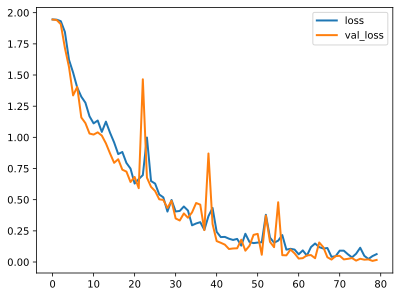

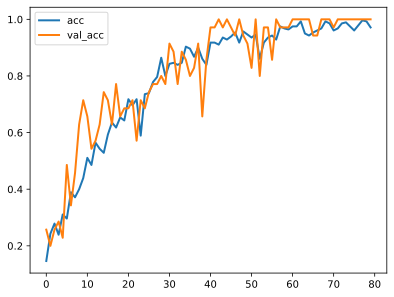

In [22]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

2/2 [==============================] - 0s 28ms/step
Precisão: 1.0


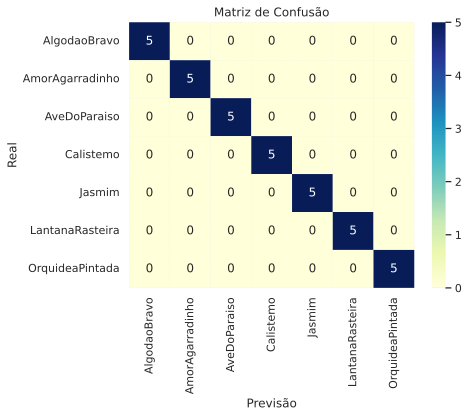

In [24]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Gerar previsões para o conjunto de dados de validação
predictions = model.predict(x_test)

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(predictions,axis=1)
predicted_classes = predicted_classes.reshape((35,1))

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = y_test

# Obter os nomes das classes
class_names = list(train_generator.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


In [25]:
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

2/2 [==============================] - 0s 18ms/step - loss: 0.1394 - accuracy: 1.0000 - top-5-accuracy: 1.0000
Test loss: 0.14
Test accuracy: 100.0%
Test top 5 accuracy: 100.0%


2/2 [==============================] - 0s 32ms/step
Precisão: 0.9714285714285714


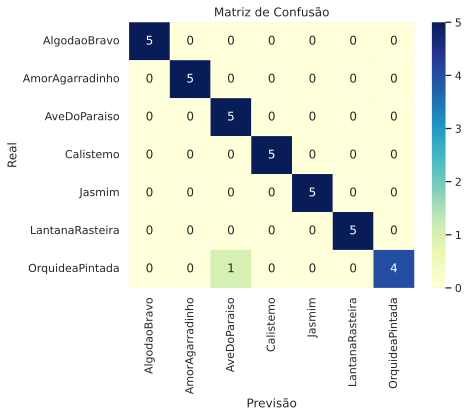

In [26]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Gerar previsões para o conjunto de dados de validação
predictions = model.predict(x_valid)

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(predictions,axis=1)
predicted_classes = predicted_classes.reshape((35,1))

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = y_valid

# Obter os nomes das classes
class_names = list(train_generator.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


In [27]:
loss, accuracy, top_5_accuracy = model.evaluate(x_valid, y_valid)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

2/2 [==============================] - 0s 18ms/step - loss: 0.1036 - accuracy: 0.9714 - top-5-accuracy: 1.0000
Test loss: 0.1
Test accuracy: 97.14%
Test top 5 accuracy: 100.0%
